In [25]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import masks
import lensing_qso_cross

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
NSIDE = 256
G_max = 20

In [31]:
fn_Cls = f'../data/Cls/Cls_G{G_max}_NSIDE{NSIDE}.npy'

In [32]:
fn_gaia = f'../data/gaia_G{G_max}.fits'
fn_rand = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
mask_names_gaia = ['mcs', 'dust']
Av_max = 0.2

In [33]:
mask_lensing = lensing_qso_cross.get_planck_lensing_mask(NSIDE)

Getting Planck lensing mask


In [34]:
map_lensing = lensing_qso_cross.get_planck_lensing_map(NSIDE)

Getting Planck lensing map


In [35]:
mask_overdensity = lensing_qso_cross.get_qso_mask(NSIDE, mask_names_gaia, Av_max=Av_max)

Getting QSO mask
256 3.1 ../data/maps/map_dust_NSIDE256.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE256.npy


In [36]:
map_overdensity = lensing_qso_cross.get_qso_overdensity_map(NSIDE, fn_gaia, fn_rand, mask_overdensity)

Getting QSO overdensity map
Applied mask, kept 0.709 of sources
Applied mask, kept 0.699 of sources


/home/ksf293/gaia-quasars-lss/notebooks/../code/lensing_qso_cross.py:93: RuntimeWarning: divide by zero encountered in true_divide
  map_overdensity = map_nqso_gaia / map_nqso_rand
/home/ksf293/gaia-quasars-lss/notebooks/../code/lensing_qso_cross.py:93: RuntimeWarning: invalid value encountered in true_divide
  map_overdensity = map_nqso_gaia / map_nqso_rand


## Plot maps & masks

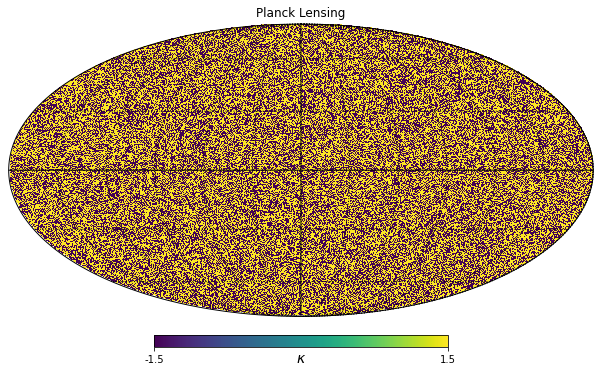

In [37]:
hp.mollview(map_lensing, title=rf"Planck Lensing", unit=r"$\kappa$",
            cmap='viridis', min=-1.5, max=1.5, #coord=['C', 'G']
)
hp.graticule()

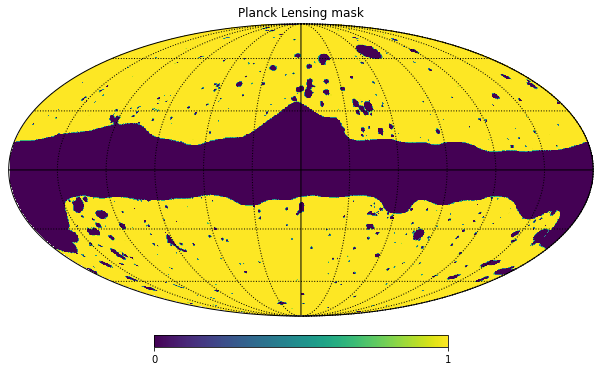

In [38]:
hp.mollview(mask_lensing, title=rf"Planck Lensing mask", unit="",
            cmap='viridis', #coord=['C', 'G']
)
hp.graticule()

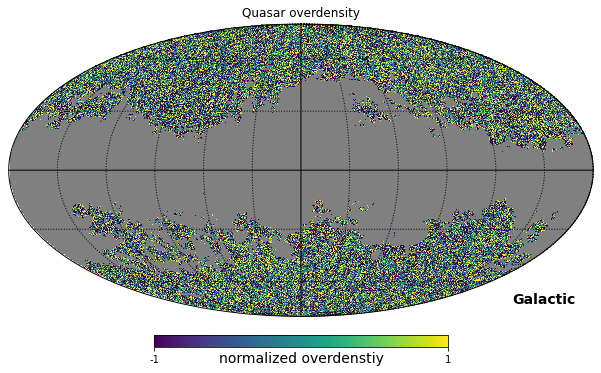

In [39]:
hp.mollview(map_overdensity, title=rf"Quasar overdensity",
    unit=r"normalized overdenstiy", cmap='viridis', coord=['C', 'G'], min=-1, max=1)
hp.graticule()

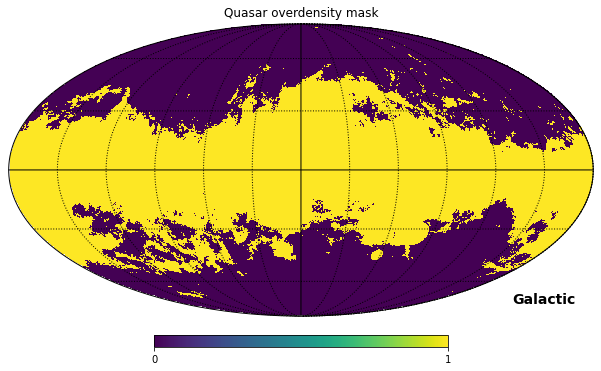

In [40]:
hp.mollview(mask_overdensity, title=rf"Quasar overdensity mask",
    unit=r"", cmap='viridis', coord=['C', 'G'], min=0, max=1)
hp.graticule()

# Do things in notebook 

In [42]:
# ell_min = 25
# ell_max = 600
# ell_bin_width = 50
# bins = lensing_qso_cross.get_bins_linear(ell_min, ell_max, ell_bin_width)

In [80]:
l0_bins = np.array([213.0373, 291.0176, 397.5417, 543.0580, 741.8391, 1013.3821, 1384.3207, 1891.0378])
lf_bins = np.array([291.0176, 397.5417, 543.0580, 741.8391, 1013.3821, 1384.3207, 1891.0378, 2583.2338])

In [82]:
l0_bins = np.around(l0_bins).astype('int')
lf_bins = np.around(lf_bins).astype('int')

In [83]:
ells = np.arange(np.amax(lf_bins))
weights = np.zeros_like(ells, dtype='float64')
bpws = -1*np.ones_like(ells)
# Careful: bins start at zero
for i in range(l0_bins.shape[0]):
    bpws[l0_bins[i]:lf_bins[i]] = i
    weights[l0_bins[i]:lf_bins[i]] = 1./(lf_bins[i]-l0_bins[i])

b = nmt.NmtBin(NSIDE, bpws=bpws, ells=ells, weights=np.ones_like(ells))

In [84]:
Cls_kk_obj = lensing_qso_cross.compute_Cls(bins, map_lensing, map_lensing, mask_lensing, mask_lensing)
Cls_kq_obj = lensing_qso_cross.compute_Cls(bins, map_lensing, map_overdensity, mask_lensing, mask_overdensity)
Cls_qq_obj = lensing_qso_cross.compute_Cls(bins, map_overdensity, map_overdensity, mask_overdensity, mask_overdensity)

Computing Cls
Computing Cls
Computing Cls


In [85]:
ell_arr = bins.get_effective_ells()

In [86]:
Cls_kk_obj.shape

(1, 12)

In [87]:
def compute_Cls(b, map1, map2, mask1, mask2):
    f1 = nmt.NmtField(mask1, [map1])
    f2 = nmt.NmtField(mask2, [map2])
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(f1, f2, b)
    # Compute pseudo-Cls
    cl_coupled = nmt.compute_coupled_cell(f1, f2)
    # Uncoupling pseudo-Cls
    # For one spin-0 field and one spin-2 field, NaMaster gives: n_cls=2, [C_TE,C_TB]
    # For two spin-2 fields, NaMaster gives: n_cls=4, [C_E1E2,C_E1B2,C_E2B1,C_B1B2]
    cl_uncoupled = wsp.decouple_cell(cl_coupled)
    #cl_out = np.vstack((ell_arr, cl_uncoupled))
    return cl_uncoupled

In [88]:
Cls_kk_obj = compute_Cls(bins, map_lensing, map_lensing, mask_lensing, mask_lensing)
Cls_kq_obj = compute_Cls(bins, map_lensing, map_overdensity, mask_lensing, mask_overdensity)
Cls_qq_obj = compute_Cls(bins, map_overdensity, map_overdensity, mask_overdensity, mask_overdensity)

In [89]:
Cls_kk_obj.shape

(1, 12)

In [90]:
Cls_kk = Cls_kk_obj[0]
Cls_kq = Cls_kq_obj[0]
Cls_qq = Cls_qq_obj[0]

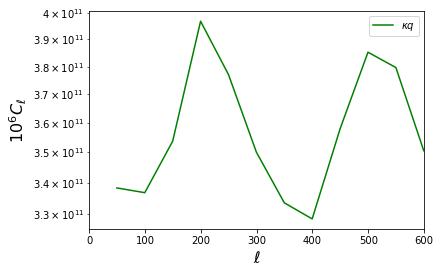

In [91]:
plt.plot(ell_arr, mult_fac*Cls_kk, 'g-', label=r'$\kappa q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

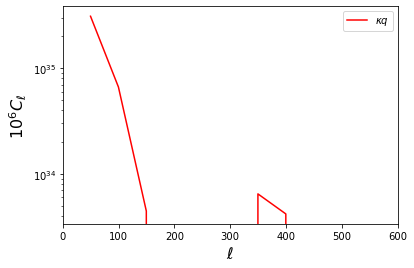

In [92]:
plt.plot(ell_arr, mult_fac*Cls_kq, 'r-', label=r'$\kappa q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

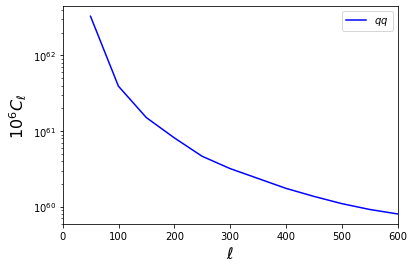

In [93]:
plt.plot(ell_arr, mult_fac*Cls_qq, 'b-', label=r'$q q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [94]:
cls_in = np.array([ell_arr, Cls_kq_obj]).T
print(cls_in)
b.bin_cell(cls_in)

[array([ 49.5,  99.5, 149.5, 199.5, 249.5, 299.5, 349.5, 399.5, 449.5,
        499.5, 549.5, 599.5])
 array([[ 3.09258156e+29,  6.63150258e+28,  4.45668350e+27,
         -2.55737282e+28, -1.95563899e+28, -7.68135644e+27,
          6.47212038e+27,  4.18652458e+27, -3.05092125e+27,
         -6.66933625e+27, -2.50744620e+27, -3.75536936e+27]])]


/state/partition1/job-23022627/ipykernel_3473417/3231327954.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cls_in = np.array([ell_arr, Cls_kq_obj]).T


ValueError: Input Cl has wrong size

In [75]:
b.lmax

624

# Load in Cl results

In [13]:
#res_Cls = np.load(fn_Cls)
#ell_arr, Cls_kk, Cls_kq, Cls_qq = res_Cls

In [15]:
mult_fac = 1e6

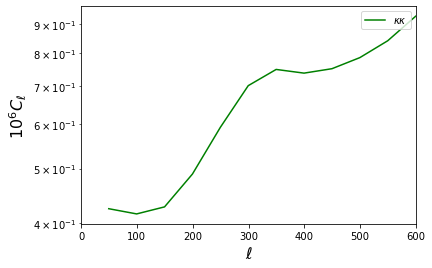

In [16]:
plt.plot(ell_arr, mult_fac*Cls_kk, 'g-', label=r'$\kappa \kappa$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

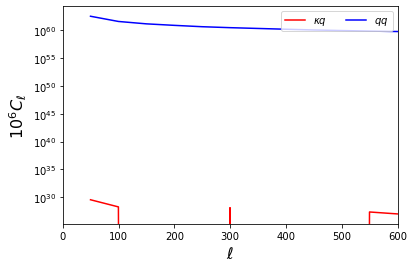

In [17]:
plt.plot(ell_arr, mult_fac*Cls_kq, 'r-', label=r'$\kappa q$')
plt.plot(ell_arr, mult_fac*Cls_qq, 'b-', label=r'$q q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

# Do things in notebook 

In [ ]:
ell_min = 25
ell_max = 600
ell_bin_width = 50
bins = get_bins_linear(ell_min, ell_max, ell_bin_width)

In [ ]:
Cls_kk_obj = compute_Cls(bins, map_lensing, map_lensing, mask_lensing, mask_lensing)
Cls_kq_obj = compute_Cls(bins, map_lensing, map_overdensity, mask_lensing, mask_overdensity)
Cls_qq_obj = compute_Cls(bins, map_overdensity, map_overdensity, mask_overdensity, mask_overdensity)

In [ ]:
ell_arr = bins.get_effective_ells()

# Visualize bandpowers

In [ ]:
# Initialize binning scheme with 4 ells per bandpower
#b = nmt.NmtBin.from_nside_linear(nside, 4)

In [19]:
ell_min = 25
ell_max = 600
ell_bin_width = 50
ell_edges = np.arange(ell_min, ell_max+ell_bin_width, ell_bin_width)
ell_ini = ell_edges[:-1]
ell_end = ell_edges[1:]
b = nmt.NmtBin.from_edges(ell_ini, ell_end)

In [23]:
print(ell_arr.shape, Cls_kk.shape)

(12,) (12,)


In [24]:
b.bin_cell(np.array([ell_arr, Cls_kk]).T)

ValueError: Input Cl has wrong size